In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
data_file = 'arrhythmia.data'
df = pd.read_csv(data_file, header=None)

In [3]:
## replicating data points with 5 or fewer samples  
from collections import Counter
class_counts = Counter(df.iloc[:,-1])   # counting class labels 
classes_to_augment = [class_label for class_label, count,  in class_counts.items() if count<6] # identify class labels to replicate 
# loop over classes to replicate
for class_label in classes_to_augment:
    class_rows = df[df.iloc[:,-1]==class_label]
     # replicate the rows until the class count reaches at least 6
    while class_counts[class_label]<6:
        df = pd.concat([df, class_rows], ignore_index=True)
        class_counts[class_label] += len(class_rows)
class_counts = Counter(df.iloc[:,-1])
for class_label, count in class_counts.items():
    print(f" Class {class_label} has {count}")

 Class 8 has 6
 Class 6 has 25
 Class 10 has 50
 Class 1 has 245
 Class 7 has 6
 Class 14 has 8
 Class 3 has 15
 Class 16 has 22
 Class 2 has 44
 Class 4 has 15
 Class 5 has 13
 Class 9 has 9
 Class 15 has 10


In [4]:
# handling missing values 
from sklearn.impute import SimpleImputer
df.replace("?", np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_data = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed_data, columns=df.columns)
print(df_imputed.shape)

(468, 280)


In [5]:
X = df_imputed.iloc[ :,:-1].values
y=df_imputed.iloc[:,-1]
print(np.shape(X))
print(np.shape(y))

(468, 279)
(468,)


In [6]:
# apply Synthetic Minority Oversampling Technique(SMOTE):

from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE(random_state=0).fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)

(3185, 279)
(3185,)


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()

# features scaling 
X_scaled = sc.fit_transform(X_res)
pca = PCA()
pca.fit(X_scaled)
pca_data = pca.transform(X_scaled)

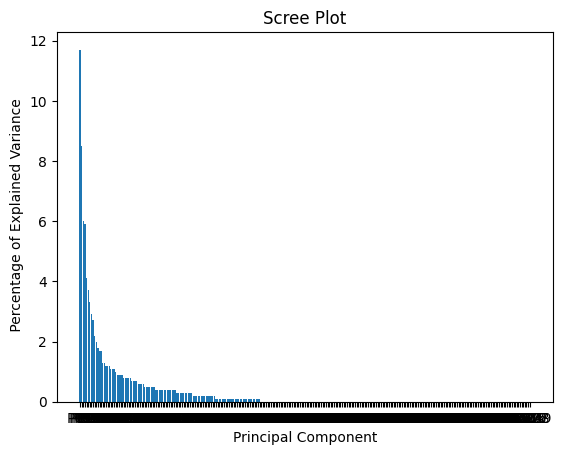

In [8]:
# compute the percentage of explained variance for each principal component
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

# create labels for the principal components 
labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]

# plotting 
plt.bar(x=range(1,len(per_var) + 1), height=per_var, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel(' Percentage of Explained Variance')
plt.title('Scree Plot')
plt.show()

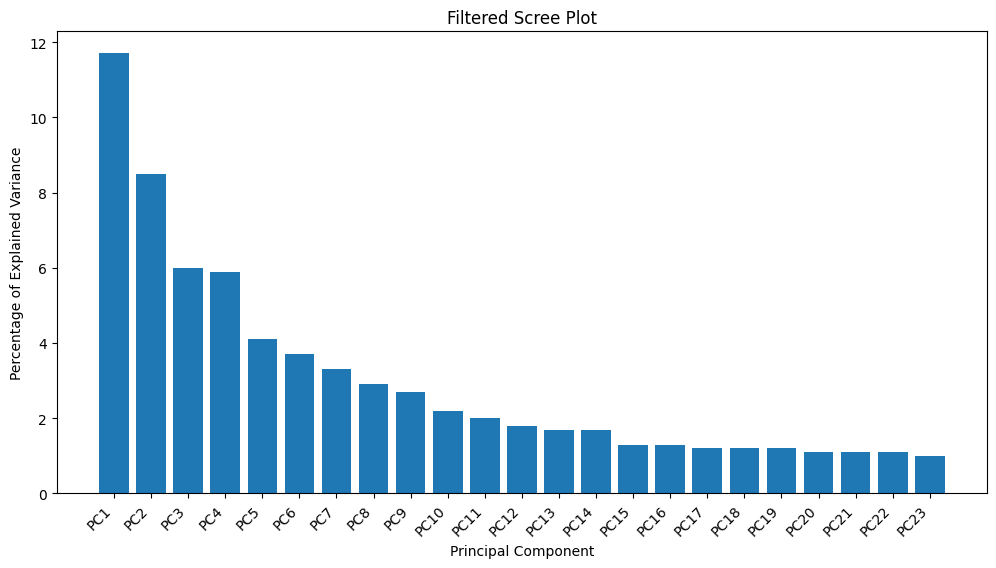

In [9]:

threshold = 1   # threshold for selecting important component 1% 

important_components = per_var[per_var >= threshold]    # select the components with explained variance greater than or equal to the threshold

# plotting 
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x=range(1, len(important_components) + 1), height=important_components, tick_label=labels[:len(important_components)])
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Filtered Scree Plot')
plt.xticks(rotation=45, ha='right')
plt.show()



In [10]:
important_indices = [i for i, variance in enumerate(per_var) if variance >= threshold]
important_pca_data = pca_data[:, important_indices]
print(important_pca_data.shape)

(3185, 23)


In [11]:
new_X = pd.DataFrame(important_pca_data)
print(new_X.shape)
print(y_res.shape)

(3185, 23)
(3185,)


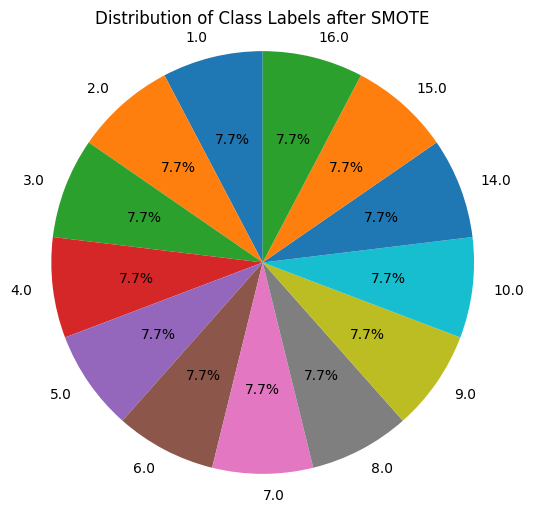

In [12]:
unique, counts = np.unique(y_res, return_counts=True)
labels = unique
sizes = counts
plt.figure(figsize=(6, 6))  # Optional: Specifies the figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Class Labels after SMOTE')
plt.show()

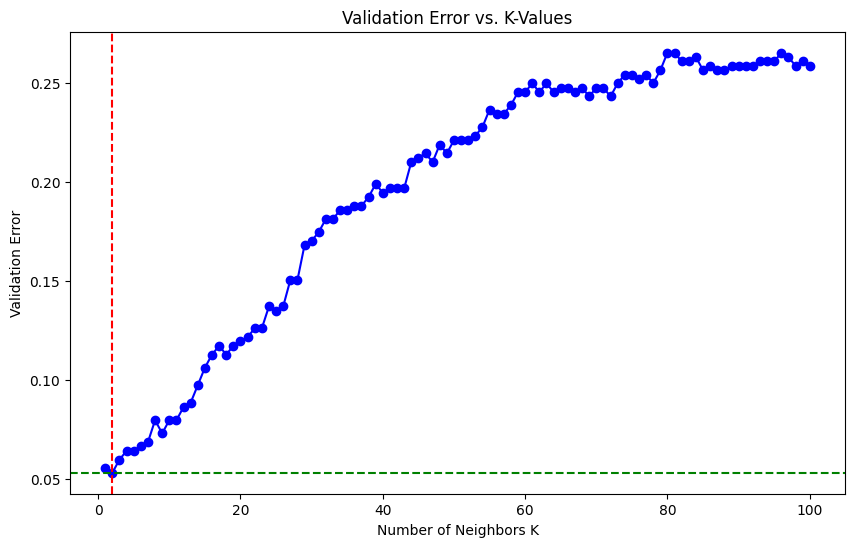

The optimal number of neighbors (opt_K) is: 2 with a minimum validation error of: 0.05309734513274336


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# split the data into training+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=0)

# split the training+validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1667, random_state=0)

k_values = range(1, 101)
val_errors = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    val_error = np.mean(y_val_pred != y_val)  
    val_errors.append(val_error)
    
min_val_error = min(val_errors)
opt_K = k_values[val_errors.index(min_val_error)]


plt.figure(figsize=(10, 6))
plt.plot(k_values, val_errors, marker='o', linestyle='-', color='b')
plt.title('Validation Error vs. K-Values')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Validation Error')
plt.axvline(x=opt_K, color='r', linestyle='--')
plt.axhline(y=min_val_error, color='g', linestyle='--')
plt.show()

print(f"The optimal number of neighbors (opt_K) is: {opt_K} with a minimum validation error of: {min_val_error}")

In [14]:
from sklearn.metrics import accuracy_score, classification_report
knn_optimal = KNeighborsClassifier(n_neighbors=opt_K)


knn_optimal.fit(X_train, y_train)


y_pred = knn_optimal.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.9581589958158996


In [15]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.88      0.45      0.60        31
         2.0       0.88      0.95      0.91        44
         3.0       1.00      1.00      1.00        38
         4.0       0.98      1.00      0.99        44
         5.0       0.87      1.00      0.93        34
         6.0       0.98      1.00      0.99        42
         7.0       1.00      1.00      1.00        28
         8.0       1.00      1.00      1.00        34
         9.0       1.00      1.00      1.00        32
        10.0       0.93      0.96      0.95        27
        14.0       0.98      1.00      0.99        43
        15.0       1.00      1.00      1.00        33
        16.0       0.96      1.00      0.98        48

    accuracy                           0.96       478
   macro avg       0.96      0.95      0.95       478
weighted avg       0.96      0.96      0.95       478



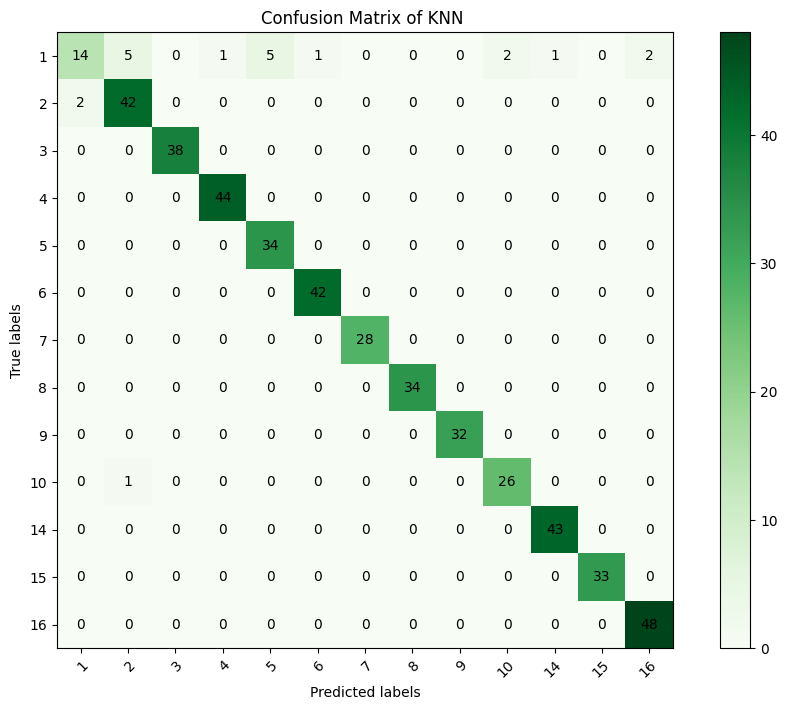

In [16]:

from sklearn.metrics import confusion_matrix

# define the labels for the confusion matrix
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16]

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# plotting 
plt.figure(figsize=(12, 8))
ax = plt.gca()

# create a heatmap of the confusion matrix
cax = ax.imshow(cm, interpolation='nearest', cmap='Greens')
plt.colorbar(cax)  

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of KNN ')
ax.grid(False)  

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

plt.show()